In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [2]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")


In [3]:
imageDf = pd.read_csv(chest_xray_dataset_annotations)
print(imageDf.finding)

0      COVID-19
1      COVID-19
2      COVID-19
3      COVID-19
4      COVID-19
         ...   
367    COVID-19
368    COVID-19
369    COVID-19
370    COVID-19
371    COVID-19
Name: finding, Length: 372, dtype: object


In [4]:
# used following resource for ref https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
# Decided to use target size of 1024, 1024 for padding as there isn't a consistent resolution

image_size = (1024, 1024)
batch_size = 10
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator=datagen.flow_from_dataframe(dataframe=imageDf, directory=chest_xray_dataset, x_col="filename", y_col="finding", class_mode="categorical", target_size=(1024,1024), batch_size=16, subset='training',crop_to_aspect_ratio=True)
validation_generator = datagen.flow_from_dataframe(dataframe=imageDf, directory=chest_xray_dataset, x_col="filename", y_col="finding", class_mode="categorical", target_size=(1024,1024), batch_size=16,subset='validation',crop_to_aspect_ratio=True)
print('test',validation_generator)


Found 281 validated image filenames belonging to 11 classes.
Found 70 validated image filenames belonging to 11 classes.
test <keras.preprocessing.image.DataFrameIterator object at 0x7f5d5040bdf0>


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 21 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


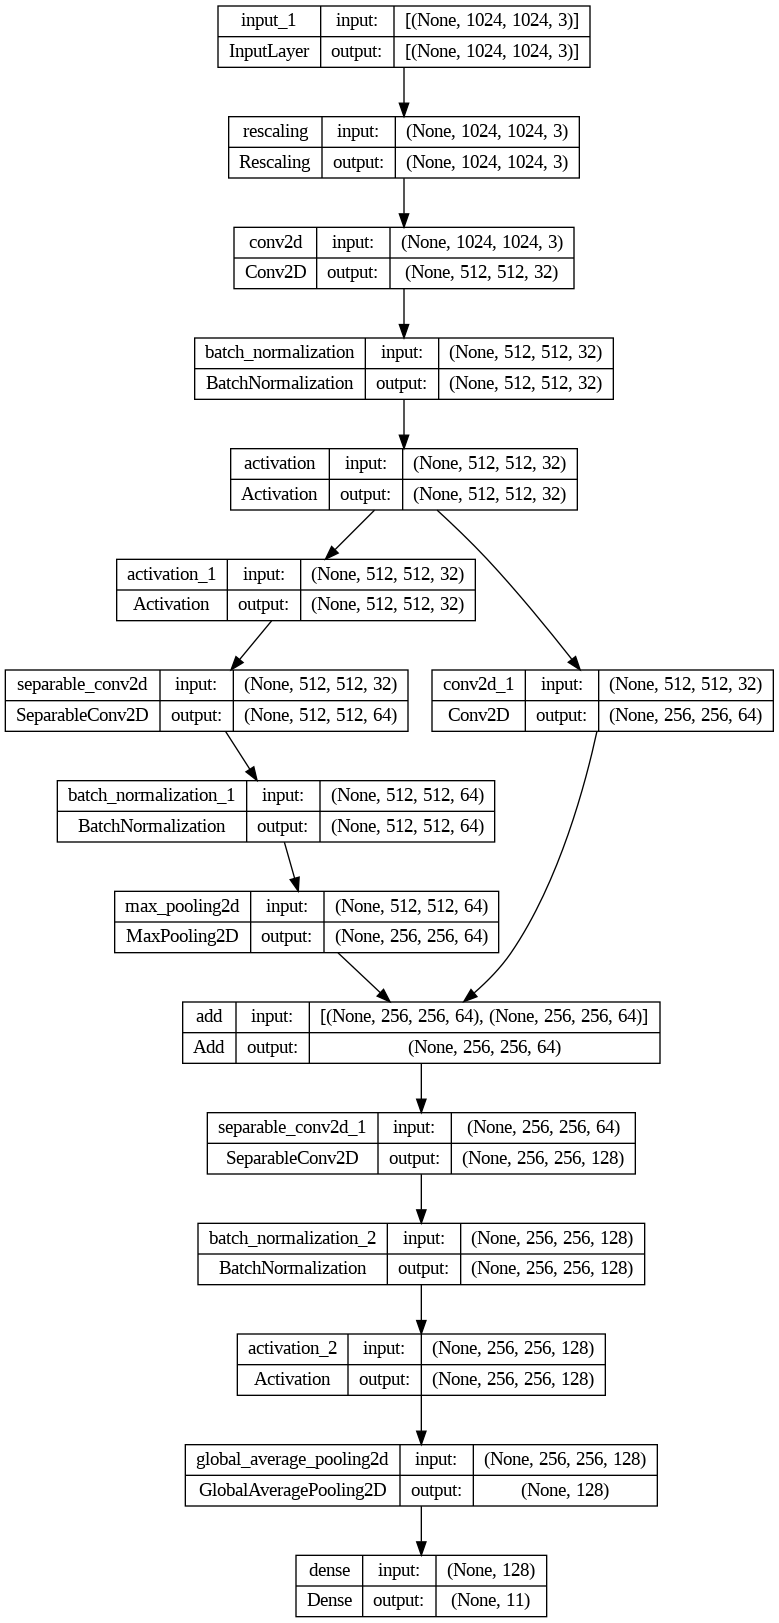

In [5]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D(11, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(64, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 11

    outputs = layers.Dense(11, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, 1024, 1024,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['rescaling[0][0]']              
                                )                                                             

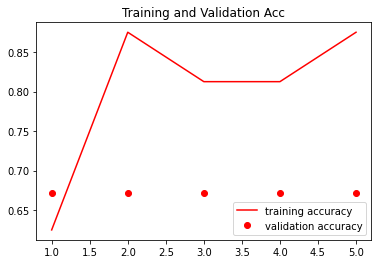

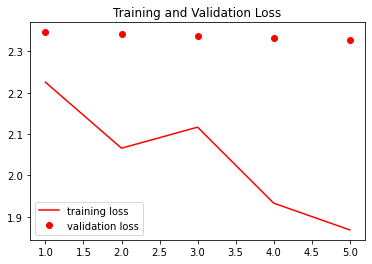

In [8]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=validation_generator)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/chest_xray_dataset_model.h5')
print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()